# Predictions with kernel on core part only

Update 10/Nov/2020
Try to use the core part only for prediction 
To see whether the uniform-like uncertainty prediction is due to the large part of same sequences (non-core part)

Upate 05/Nov/2020
Update plots for 7 reps for round 1.

Update 29/Oct/2020  
We now have Round 1's results. We observe that the consensus sequence has very different labels for different plates/rounds. So we decide to normalise to the consensus sequence (before log normalisation and z-normalisation, subtract the mean of each consensus sequence mean in each plate/round). We will call the normalisation methods as **plate normalisation** and **round normalisation** respectively.
Let's see how the predictions look like for different normalisation methods on the following training/testing pairs
- train 80% round 0 and test 20% round 0
- train round 0 and test round 1
- train 80% all data (round 0 + 1) and test the rest

As always, we consider GPR with RBF, one-hot as a baseline model we would like to compare with.
Our model GPR with wd kernel with shift.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

import pickle
import xarray

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Read Data and Set Up

In [2]:

# round normalisation
roundRep_Path = '../../data/Results_Microplate_partialFalse_normTrue_roundRep_formatSeq_logTrue.csv'
round_df = pd.read_csv(roundRep_Path)
round_df

,Unnamed: 0,Name,Group,Plate,Round,RBS,RBS6,Rep1,Rep2,Rep3,...,Rep5,Rep6,Rep7,Rep8,Rep9,AVERAGE,STD,Pred Mean,Pred Std,Pred UCB
0,0,RBS_1by1_0,reference,First_Plate,0,TTTAAGAAGGAGATATACAT,AGGAGA,2.433056,2.502155,2.315237,...,2.917124,2.275329,NaN,NaN,NaN,2.575968,0.313540,NaN,NaN,NaN
1,1,RBS_1by1_1,bps_noncore,First_Plate,0,CTTAAGAAGGAGATATACAT,AGGAGA,1.556251,1.654243,1.762146,...,2.312790,1.959275,NaN,NaN,NaN,1.839138,0.268820,NaN,NaN,NaN
2,2,RBS_1by1_2,bps_noncore,First_Plate,0,GTTAAGAAGGAGATATACAT,AGGAGA,0.603551,0.748674,0.921939,...,0.503846,0.711231,NaN,NaN,NaN,0.646754,0.188587,NaN,NaN,NaN
3,3,RBS_1by1_3,bps_noncore,First_Plate,0,ATTAAGAAGGAGATATACAT,AGGAGA,1.658359,1.874275,1.534988,...,1.747116,1.232548,NaN,NaN,NaN,1.598899,0.220191,NaN,NaN,NaN
4,4,RBS_1by1_4,bps_noncore,First_Plate,0,TCTAAGAAGGAGATATACAT,AGGAGA,1.545942,2.072095,1.386300,...,1.774833,2.146898,NaN,NaN,NaN,1.812638,0.300722,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,261,RBS_BA_1658,bandit2,Third_Plate,1,TTTAAGAGCTAAGTATACAT,GCTAAG,0.710566,0.329651,0.739814,...,0.984787,1.027128,0.722992,NaN,NaN,0.784134,0.256830,0.677239,0.634139,1.945517
262,262,RBS_BA_1548,bandit2,Third_Plate,1,TTTAAGAGCGGAGTATACAT,GCGGAG,2.371112,2.130169,1.840573,...,1.519450,1.684631,1.469772,NaN,NaN,1.824837,0.369508,0.789158,0.576882,1.942922
263,263,RBS_BA_2887,bandit2,Third_Plate,1,TTTAAGACTCTACTATACAT,CTCTAC,0.472520,0.419643,0.084277,...,0.917125,0.936878,0.647006,NaN,NaN,0.598548,0.333065,0.813209,0.564510,1.942230
264,264,RBS_BA_3330,bandit2,Third_Plate,1,TTTAAGATGGTTATATACAT,TGGTTA,0.673195,0.650845,0.662154,...,1.090485,0.913889,0.792242,NaN,NaN,0.800462,0.175970,0.706033,0.617109,1.940251


In [3]:
def run_kfold(df,kernel, embedding, train_idx = None, test_idx = None, 
              num_split = 5,num_repeat = 10,s_list = [1],alpha_list= [2],l_list = [6]):
    gpr = GPR_Predictor(df, train_idx = train_idx, test_idx = test_idx, embedding = embedding, kernel_name = kernel)
    result_DataArray_wd = gpr.Repeated_kfold(num_split=num_split, num_repeat=num_repeat, alpha_list= alpha_list,
                                          l_list = l_list, s_list = s_list)
    # print(result_DataArray_wd[1].mean(axis = -1).mean(axis=-1))
    return result_DataArray_wd

def run_regression(df,kernel, embedding, train_idx = None, test_idx = None, 
               eva_metric = [mean_squared_error, r2_score], l = 6, s = 1, alpha = 2, eva_on='seqs', title = 'Prediction'):
    # train and test on round 0
    gpr_train_samples = GPR_Predictor(df, train_idx= train_idx, test_idx=test_idx, kernel_name = kernel, embedding = embedding,     
                                    eva_metric = eva_metric, l = l, s = s, alpha = alpha, eva_on=eva_on)
    gpr_train_samples.regression()
    gpr_train_samples.scatter_plot(title = title)
    gpr_train_samples.line_plot()
    return gpr_train_samples


## Train and Test on All Rounds Data

X train shape:  (1276, 20)
X test shape:  (53, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7f7e19c55488>
Train:  0.22539278304345262
Test:  0.5051850341845001
<function r2_score at 0x7f7e19c556a8>
Train:  0.746229550045352
Test:  0.3373291049432786


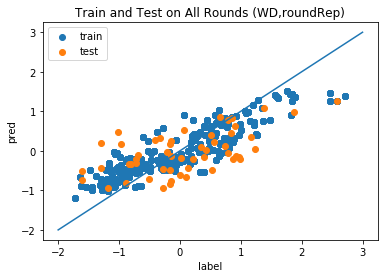

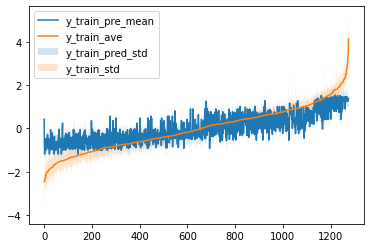

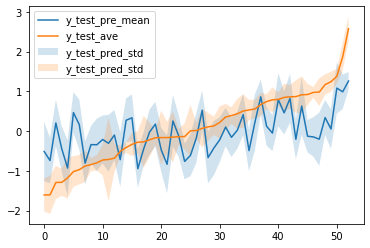

In [4]:
# setting
kernel = 'WD_Kernel_Shift' # 'RBF'
embedding = 'label' # 'onehot'

predict_round_df = run_regression(round_df, kernel, embedding, title = 'Train and Test on All Rounds (WD,roundRep)')

(array([1., 0., 2., 1., 2., 7., 2., 4., 2., 2.]),
 array([0.51030363, 0.53623098, 0.56215833, 0.58808567, 0.61401302,
        0.63994037, 0.66586772, 0.69179506, 0.71772241, 0.74364976,
        0.76957711]),
 <a list of 10 Patch objects>)

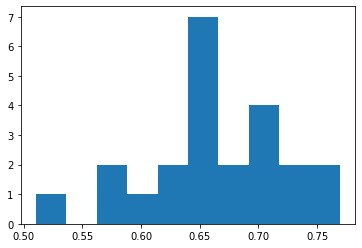

In [5]:
plt.hist(predict_round_df.test_df['Pred Std'])

In [6]:
# use core part only

round_df_core = round_df[round_df['Group'] != 'bps_noncore']
round_df_core.reset_index(inplace=True, drop=True)
round_df_core['RBS'] = round_df_core['RBS6']
round_df_core

,Unnamed: 0,Name,Group,Plate,Round,RBS,RBS6,Rep1,Rep2,Rep3,...,Rep5,Rep6,Rep7,Rep8,Rep9,AVERAGE,STD,Pred Mean,Pred Std,Pred UCB
0,0,RBS_1by1_0,reference,First_Plate,0,AGGAGA,AGGAGA,2.433056,2.502155,2.315237,...,2.917124,2.275329,NaN,NaN,NaN,2.575968,0.313540,NaN,NaN,NaN
1,20,RBS_1by1_21,bps_core,First_Plate,0,AGGAGA,AGGAGA,0.007604,0.254945,0.688366,...,-0.179961,0.303690,NaN,NaN,NaN,0.227330,0.295688,NaN,NaN,NaN
2,21,RBS_1by1_22,bps_core,First_Plate,0,CGGAGA,CGGAGA,0.568228,0.860005,0.138287,...,0.664466,1.102469,NaN,NaN,NaN,0.669757,0.321392,NaN,NaN,NaN
3,22,RBS_1by1_23,bps_core,First_Plate,0,GGGAGA,GGGAGA,-0.802179,-0.533759,0.575773,...,-0.500263,-0.411978,NaN,NaN,NaN,-0.380927,0.486872,NaN,NaN,NaN
4,23,RBS_1by1_24,bps_core,First_Plate,0,TGGAGA,TGGAGA,1.099618,0.885131,-0.309000,...,1.124688,0.660596,NaN,NaN,NaN,0.696318,0.528047,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,261,RBS_BA_1658,bandit2,Third_Plate,1,GCTAAG,GCTAAG,0.710566,0.329651,0.739814,...,0.984787,1.027128,0.722992,NaN,NaN,0.784134,0.256830,0.677239,0.634139,1.945517
221,262,RBS_BA_1548,bandit2,Third_Plate,1,GCGGAG,GCGGAG,2.371112,2.130169,1.840573,...,1.519450,1.684631,1.469772,NaN,NaN,1.824837,0.369508,0.789158,0.576882,1.942922
222,263,RBS_BA_2887,bandit2,Third_Plate,1,CTCTAC,CTCTAC,0.472520,0.419643,0.084277,...,0.917125,0.936878,0.647006,NaN,NaN,0.598548,0.333065,0.813209,0.564510,1.942230
223,264,RBS_BA_3330,bandit2,Third_Plate,1,TGGTTA,TGGTTA,0.673195,0.650845,0.662154,...,1.090485,0.913889,0.792242,NaN,NaN,0.800462,0.175970,0.706033,0.617109,1.940251


X train shape:  (1079, 6)
X test shape:  (45, 6)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7f7e19c55488>
Train:  0.2568536565128396
Test:  0.8258496461538727
<function r2_score at 0x7f7e19c556a8>
Train:  0.6337145074893716
Test:  0.21783378962522604


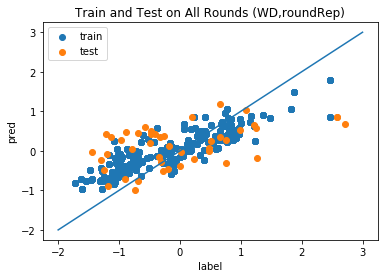

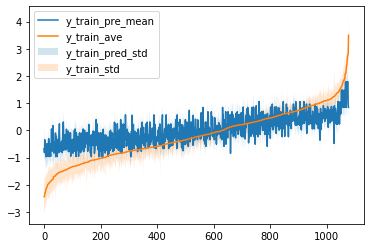

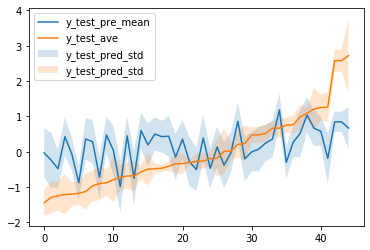

In [7]:
# setting
kernel = 'WD_Kernel_Shift' # 'RBF'
embedding = 'label' # 'onehot'

predict_round_df_core = run_regression(round_df_core, kernel, embedding, title = 'Train and Test on All Rounds (WD,roundRep)')

(array([1., 1., 3., 5., 1., 3., 2., 4., 1., 2.]),
 array([0.57010592, 0.58776107, 0.60541622, 0.62307137, 0.64072652,
        0.65838167, 0.67603682, 0.69369197, 0.71134712, 0.72900227,
        0.74665742]),
 <a list of 10 Patch objects>)

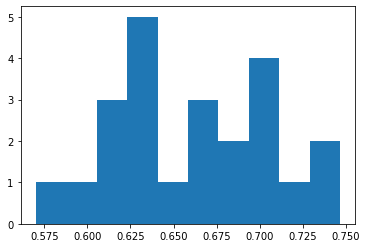

In [8]:
plt.hist(predict_round_df_core.test_df['Pred Std'])

In [9]:
# kernel = 'RBF'
# embedding = 'onehot'
# eva_metric = [mean_squared_error, r2_score]

# # gpr_train_samples = GPR_Predictor(df, kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
# #                    alpha = 2, eva_on='seqs')

# # train and test on round 0
# gpr_train_samples = GPR_Predictor(df[df['Plate'] != 'Third_Plate'], kernel_name = kernel, embedding = embedding, eva_metric = eva_metric, alpha = 2, eva_on='seqs')

# # train on round 0 (plate 1 and 2) and test on round 1 (plate 3)
# # gpr_train_samples = GPR_Predictor(df, train_idx= df['Plate'] != 'Third_Plate', test_idx= df['Plate'] == 'Third_Plate', 
# #                    kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
# #                    l = 6, s = 1, alpha = 2, eva_on='seqs')
# gpr_train_samples.regression()
# gpr_train_samples.scatter_plot()

## Conclusion

The range of uncertainty prediction on testing dataset do not have clear difference between using the whole sequence and only using the core part.